University of Michigan - ROB 101 Computational Linear Algebra

# Soft Margin Classifier

In [1]:
using Pkg
Pkg.add("OSQP")
Pkg.add("Compat")

    Updating registry at `C:\Users\maanigj\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\maanigj\.julia\environments\v1.6\Manifest.toml`


**Soft Margin Classifier**

\begin{split}\begin{array}{ll}
  \mbox{minimize}_{\xi,w} & \frac{1}{2} \xi^\top \xi + \frac{\lambda}{2} w^\top w \\
  \mbox{subject to} & y_i (w^\top x_i) \geq 1 - \xi_i \qquad i = 1,\dots,n
\end{array}\end{split}

We can write this as

\begin{split}\begin{array}{ll}
  \mbox{minimize}_{\xi,w} & \frac{1}{2} \begin{bmatrix} w \\ \xi \end{bmatrix}^\top \begin{bmatrix} \lambda I_m & 0_{m\times n} \\ 0_{n\times m} & I_n \end{bmatrix} \begin{bmatrix} w \\ \xi \end{bmatrix} \\
  \mbox{subject to} & \begin{bmatrix} -\infty_n \\ 0_n \end{bmatrix} \leq \begin{bmatrix} \Phi_{n\times m} & -I_n \\ 0_{n\times m} & I_n \end{bmatrix} \begin{bmatrix} w \\ \xi \end{bmatrix} \leq \begin{bmatrix} -1_n \\ \infty_n \end{bmatrix}
\end{array}\end{split}

where $$ \Phi_{n\times m} = \begin{bmatrix} -y_1 x_1^\top \\ \vdots \\ -y_n x_n^\top \end{bmatrix}.$$

In [20]:
# generate a dataset
n = 200; # number data points
stop = false;
k1 = 0; # number of 1
k2 = 0; # number of -1
X = zeros(n,2); # input matrix
t = zeros(n,1); # target values
i = 1;
while !stop
    x = rand(1,2) * 10.;
    # separating line is x2 = 1.5 x1 + 0.4
    y = x[2] - 1.5 * x[1] - 0.4;
    # generate target values
    if (y > -3.1) && k1 < n/2
        t[i] = 1;
        X[i,:] = x;
        k1 += 1;
        i += 1;
    elseif (y < 3.1) && k2 < n/2
        t[i] = -1;
        X[i,:] = x;
        k2 += 1;
        i += 1;
    elseif k1 > (n/2-1) && k2 > (n/2-1)
        break;
    end
end

# Class +1 IDs
class1_id = t .== 1;

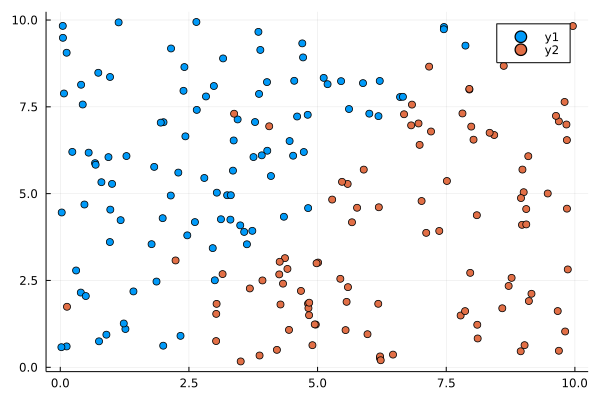

In [21]:
using Plots
gr() # Set the backend to GR

plot(X[class1_id[:],1], X[class1_id[:],2], seriestype = :scatter)
plot!(X[.!class1_id[:],1], X[.!class1_id[:],2], seriestype = :scatter)

In [22]:
using OSQP
using SparseArrays
using LinearAlgebra 

# Define problem data
m = 3;
λ = 1; # tunable parameter (called hyperparameter because it's not like w the parameter of our model)
P = sparse([λ*(zeros(m,m) + I) zeros(m,n); zeros(n,m) (zeros(n,n) + I)]);
q = zeros(n+m,1);
A = [-sparse([t t t] .* [X ones(n,1)]) -(zeros(n,n) + I); zeros(n,m) (zeros(n,n) + I)]
l = [zeros(n,1) .- Inf; zeros(n,1)];
u = [-ones(n,1); zeros(n,1) .+ Inf];

# Crate OSQP object
prob = OSQP.Model()

# Setup workspace and change alpha parameter
OSQP.setup!(prob; P=P, q=q[:], A=A, l=l[:], u=u[:])

# Solve problem
results = OSQP.solve!(prob);

println(results.x)

[-0.5560942012050832, 0.38519260742384914, 0.7035101714770599, 2.6241716575137697e-8, 1.9645136749768662e-7, 2.428032863554617e-7, 0.42707963301221186, 1.4945279916309415e-7, 2.0047880834168088e-7, 0.2540463460965594, 0.26534447776123715, 1.0303383338414098e-7, 8.987866119098984e-8, 1.2161697897789874e-7, 6.2932073370005e-8, 1.3731609984983268e-7, 1.0239401004482089e-7, 0.666414173800882, 0.31251128603950107, 2.0324305901393556e-7, 1.2089813574091348, 0.5293580280330079, 2.519811723488424e-7, 2.9076766671512614e-8, 1.118270574133507e-7, 1.1528561039349501e-7, 0.9707045996607447, 9.051571541352395e-8, 1.034650583496711e-7, 2.1188861513879474e-7, 1.9357430401932932e-7, 1.33774628225522e-7, 0.7951433151870473, 0.18716588233824522, 0.36312236230910544, 1.1739561563744476e-7, 0.1337937999022985, 1.314236801167728e-7, 0.782496251202621, 1.6135826762523112e-7, 0.5369236484694944, 2.1763403665151164e-7, 1.48126717265398e-7, 1.593585395398238e-7, 0.3104125443419514, 1.296332342935779e-7, 0.2871

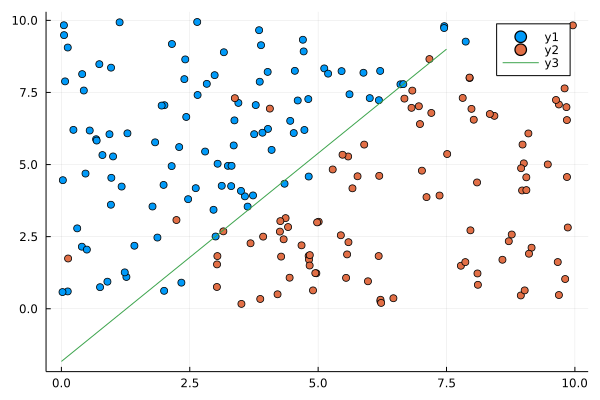

In [23]:
w_line = -results.x ./ results.x[2];

x_line = collect(0:0.1:7.5)
y_line = w_line[1] * x_line .+ w_line[3]
plot!(x_line, y_line)